## Red-Black Tree Example

In [1]:
from __future__ import annotations
from dataclasses import dataclass
from gvdot import Dot, Markup

### Representation

In [2]:
RED   = 1
BLACK = 0

@dataclass
class RBNode:
    key    : int
    color  : int
    left   : RBNode | None = None
    right  : RBNode | None = None


### Example Instance


In [3]:
example = RBNode(
    59,BLACK,
    RBNode(
        51,RED,
        RBNode(
            34,BLACK,
            RBNode(18,RED),
            RBNode(43,RED)),
        RBNode(58,BLACK)),
    RBNode(71,BLACK))

### Implementation

#### Theme Definition

In [4]:
rb_theme = (Dot()
    .graph(fontname="Georgia", fontsize=12)
    .all_default(color="#000000", penwidth=1.5)
    .node_default(fontname="Helvetica", fontsize=14, fontcolor="#eeeeee",
                  style="filled", shape="circle", fixedsize=True, height=0.35)
    .edge_default(arrowhead="none")
    .node_role("red", fillcolor="#f31020")
    .node_role("black", fillcolor="#001122")
    .all_role("phantom", style="invisible", label=""))

#### Diagram Construction

In [5]:
def rb_diagram(root:RBNode, description:str):

    def traverse(node):
        if node:
            yield node
            yield from traverse(node.left)
            yield from traverse(node.right)

    dot = Dot(directed=True).use_theme(rb_theme)
    dot.graph(label=Markup(f"<br/>{description}<br/> "))

    phantom_index = 1

    def link(node:RBNode, child:RBNode|None) -> int|str:
        if child is not None:
            dot.edge(node.key, child.key)
            return child.key
        else:
            nonlocal phantom_index
            phantom_id = "_phantom_" + str(phantom_index)
            phantom_index += 1
            dot.node(phantom_id, role="phantom")
            dot.edge(node.key, phantom_id, role="phantom")
            return phantom_id

    for node in traverse(root):
        dot.node(node.key, role="red" if node.color == RED else "black")
        if node.left or node.right:
            c1 = link(node, node.left)
            c2 = link(node, None)
            c3 = link(node, node.right)
            subdot = dot.subgraph().graph(rank="same")
            subdot.edge(c1,c2,role="phantom").edge(c2,c3,role="phantom")

    return dot

### Rendering

#### Showing in the Notebook

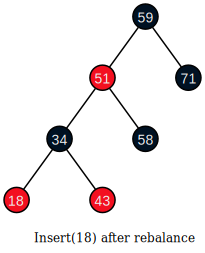

In [6]:
diagram = rb_diagram(example, "Insert(18) after rebalance")
diagram.show()

#### Saving as an SVG File

In [7]:
with open("red-black-tree.svg","w") as f:
    print(diagram.to_svg(), file=f)

#### The DOT Language Representation

In [8]:
diagram.show_source()

digraph {

    graph [color="#000000" penwidth=1.5]
    node [color="#000000" penwidth=1.5 fontname=Helvetica fontsize=14 fontcolor="#eeeeee" style=filled shape=circle fixedsize=true height=0.35]
    edge [color="#000000" penwidth=1.5 arrowhead=none]

    fontname=Georgia
    fontsize=12

    59 [fillcolor="#001122"]
    _phantom_1 [style=invisible label=""]
    51 [fillcolor="#f31020"]
    _phantom_2 [style=invisible label=""]
    34 [fillcolor="#001122"]
    _phantom_3 [style=invisible label=""]
    18 [fillcolor="#f31020"]
    43 [fillcolor="#f31020"]
    58 [fillcolor="#001122"]
    71 [fillcolor="#001122"]

    59 -> 51
    59 -> _phantom_1 [style=invisible label=""]
    59 -> 71
    51 -> 34
    51 -> _phantom_2 [style=invisible label=""]
    51 -> 58
    34 -> 18
    34 -> _phantom_3 [style=invisible label=""]
    34 -> 43

    subgraph {
        rank=same
        51 -> _phantom_1 [style=invisible label=""]
        _phantom_1 -> 71 [style=invisible label=""]
    }

    subgraph {
        rank=same
        34 -> _phantom_2 [style=invisible label=""]
        _phantom_2 -> 58 [style=invisible label=""]
    }

    subgraph {
        rank=same
        18 -> _phantom_3 [style=invisible label=""]
        _phantom_3 -> 43 [style=invisible label=""]
    }

    label=<<br/>Insert(18) after rebalance<br/> >
}